# Data and functions

In [12]:
shhh <- suppressPackageStartupMessages # It's a library, so shhh!

shhh(suppressWarnings(library(ggplot2)))   # for plotting results
shhh(suppressWarnings(library(gridExtra))) # for adding plots together
shhh(suppressWarnings(library(grid)))      # for plot grid title formatting
shhh(suppressWarnings(library(gtools)))    # for converting pvalues to stars
shhh(suppressWarnings(library(Hmisc)))
shhh(suppressWarnings(library(plyr)))      # for ddply (aggregating results)
shhh(suppressWarnings(library(tidyr)))     # for creating long table (function gather)
shhh(suppressWarnings(library(multcomp)))  # for multiple comparison tests
shhh(suppressWarnings(library(varhandle))) # for unfactoring variables
shhh(suppressWarnings(library(Rmisc)))     # for getting summary data frame

shhh(suppressWarnings(library(aplpack)))   # for bi-variate outlier, bgplot
shhh(suppressWarnings(library(WRS2)))      # for percentage bend correlation coefficient 
                   #   https://link-springer-com.ezp.lib.cam.ac.uk/content/pdf/10.1007/BF02294395.pdf
shhh(suppressWarnings(library(WRS)))       # for Wilcox correlation functions (skipped correlations)
                   # To install: 
                   # install.packages("devtools")
                   # library("devtools")
                   # Then follow: https://github.com/nicebread/WRS
                   #     Wilcox R. R. (2005). Introduction to Robust Estimation and Hypothesis Testing. 
                   #                          New York, NY: Elsevier Academic Press
                   #     https://www-ncbi-nlm-nih-gov.ezp.lib.cam.ac.uk/pmc/articles/PMC3342588/
shhh(suppressWarnings(library(MASS)))      # WRS2 uses it. Its select function conflicts with dplyr select!

shhh(suppressWarnings(library(tidyverse)))
shhh(suppressWarnings(library(ggpubr)))
shhh(suppressWarnings(library(rstatix)))

In [9]:
# Load percent-signal-change data
data_psc <- read.csv('data/psc.csv')
data_psc$roi = as.factor(data_psc$roi)
data_psc$subid = as.factor(data_psc$subid)
# Load behavioural data
data_beh <- read.csv('data/behavioural.csv')
data_beh$subid = as.factor(data_beh$subid)

# SIF data only from the behavioural
data_sif <- subset(data_beh[c(1:5)])
data_sif  <- data_sif [complete.cases(data_sif ),]

# Intrusion data only from the behavioural
data_intr <- subset(data_beh[c(1:3,7:ncol(data_beh))])
data_intr  <- data_intr [complete.cases(data_intr ),]

# Merge SIF and Intrusion data
data_sif.intr <- merge(data_sif, data_intr[c(3:ncol(data_intr))], by = 'subid')

# Merge SIF and PSC data
data_sif.psc <- merge(data_sif, data_psc[c(3:ncol(data_psc))], by = 'subid')

# Merge Intrusion and PSC data
data_intr.psc <- merge(data_intr, data_psc[c(3:ncol(data_psc))], by = 'subid')

In [7]:
# GET OUTLIERS (from a variable pair, for correlations)
# =======================================================
get_outliers <-
  function(var1,var1name,var1y,
           var2,var2name,var2y,
           disp) {
    par(mfrow = c(1, 3)) # to put the 2 univariate and 1 bivariate plots together
    
    # UNIVARIATE, boxplot method
    # ------------------------------------
    bpVar1 <- boxplot(var1,main = var1name,ylab = var1y,plot = disp)
    bpVar2 <- boxplot(var2,main = var2name,ylab = var2y,plot = disp)
    # oVar1
    ifelse(length(bpVar1$out) == 0,
      oVar1 <- vector(mode = "numeric", length = 0),
      oVar1 <- which(var1 %in% bpVar1$out)
    )
    # oVar2
    ifelse(length(bpVar2$out) == 0,
      oVar2 <- vector(mode = "numeric", length = 0),
      oVar2 <- which(var2 %in% bpVar2$out)
    )
    
    # BI-VARIATE, bagplot method
    # ------------------------------------
    # A bagplot is a bivariate generalization of the  boxplot. A bivariate boxplot.
    bpl <- compute.bagplot(var1, var2)
    # oBiv
    ifelse(is.null(bpl$pxy.outlier),
      oBiv <- vector(mode = "numeric", length = 0),
      oBiv <- which(var1 %in% bpl$pxy.outlier[, 1])
    )
    bp <-
      bagplot(
        var1,var2,
        ylab = var2name,xlab = var1name,
        main = 'bi-variate',
        cex = 2,
        create.plot = disp
      )
    # Report results
    # ------------------------------------
    if(disp){
            # var1
            print(sprintf('%s outliers: %d', var1name, length(bpVar1$out)))
            print(oVar1)
            # var2
            print(sprintf('%s outliers: %d', var2name, length(bpVar2$out)))
            print(oVar2)
            # bi-var
            print(sprintf('Bi-variate outliers: %d', length(oBiv)))
            print(oBiv)
        }
    # Return results
    # ------------------------------------
    all        <- c(oVar1, oVar2, oBiv)
    univariate <- c(oVar1, oVar2)
    bivariate  <- oBiv    
    return(list(all, univariate, bivariate))
  }

  # DO CORRELATIONS 
# Depending on the data, 3 types of correlations possible. Following recommendations by Pernet et al.(2013)
# =======================================================
doCorrelation <- function(var1, var2, outliers) {
  # WHICH CORRELATION
  # ------------------------------------
  isOutliers   <- length(outliers[[1]]) > 0
  isUnivariate <- length(outliers[[2]]) > 0
  isBivariate  <- length(outliers[[3]]) > 0
  isNormal     <- (shapiro.test(var1)$p.value > 0.05 & shapiro.test(var2)$p.value > 0.05)
  
  # if is Bivariate do Spearman skipped, using the minimum covariance determinant (MCD) estimator 
  if (isBivariate) {
    # corRes <-
    #   scorci(var1,var2,nboot = 1000,corfun = spear,plotit = FALSE)
    # r <- corRes$cor.est
    # p <- corRes$p.value
    # f <- 'Spearman skipped'
    corRes <-
      mscor(data.frame(var1,var2), corfun = spear, cop = 3)
    r <- corRes$cor[2]
    p <- 2*pt(-abs(corRes$test.stat[2]), df = length(var1)-1)
    f <- 'Spearman skipped'
    subs <- 'ss'  
  }
  
  # if is not Bivar but is Univar or is not Normal, do 20% Bend
  if (!isBivariate & (isUnivariate | !isNormal)) {
    corRes <-
      pbcor(var1,var2,beta = 0.2)
    r <- corRes$cor
    p <- corRes$p.value
    f <- 'Percentage-bend'
    subs <- 'pb' 
  }
  
  # if no outliers and is normal do Pearson
  if (!isOutliers & isNormal) {
    corRes <-
      rcorr(var1,var2)
    r <- corRes$r[2]
    p <- corRes$P[2]
    f <- 'Pearson'
    subs <- ''  
  }
    
  pval <- ifelse(p < 0.001, "p < 0.001", sprintf("p = %.3f", p))
    
  corResTxt <- bquote(.(f) ~ "correlation" ~ r[.(subs)] == .(sprintf("%.3f, %s", r, pval)))
  return(corResTxt)
}

# PLOT CORRELATIONS (with 95%CI)
# ------------------------------------
plotCorrelation <- function(var1, var2, var1name, var2name, resTXT, 
                            pointsize, txtsize, outliers = NULL, plotoutliers = FALSE) {
  if(!is.null(outliers) & length(outliers[[1]]) > 0) {
    out1 <- var1[outliers[[1]]]
    out2 <- var2[outliers[[1]]] 
    outdata <- data.frame(out1, out2)      
      
    var1 <- var1[-c(outliers[[1]])]
    var2 <- var2[-c(outliers[[1]])]
    ifelse(plotoutliers == TRUE, 
           addTxt <- sprintf('\n Outliers (n=%d) displayed in red',length(unique(outliers[[1]]))),
           addTxt <- sprintf('\n Outliers (n=%d) not displayed',length(unique(outliers[[1]])))
           )
    resTXT <- bquote(atop(.(resTXT), .(addTxt)))      
    #resTXT <- paste(resTXT, sprintf('\n Outliers (n=%d) not displayed',length(unique(outliers[[1]]))))        
  }
  
  dataset <- data.frame(var1, var2)

  corplot <- ggplot(dataset, aes(var1, var2)) +
    geom_smooth(
      method = lm, formula = y ~ x, level = 0.95,
      color = "black", fill = "grey", size = 0.2
    ) +
    geom_point(
      colour = "black", alpha = .9, fill = 'grey',
      size = pointsize, stroke = 0.2, shape = 21
    ) +    
    labs(x = var1name, y = var2name, title = resTXT) +     
    theme_minimal() + 
    theme(text = element_text(size = txtsize), 
          plot.title = element_text(hjust = 0.5, size = 11, face="bold"), 
          plot.background = element_rect(colour = "lightgrey", size = 0.4, linetype = "dotted"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank() 
          )
    
    if(!is.null(outliers) & length(outliers[[1]]) > 0 & plotoutliers == TRUE) {
        corplot <- corplot + geom_point(data = outdata, aes(out1, out2), color = 'red')
    }
    return(corplot)
}


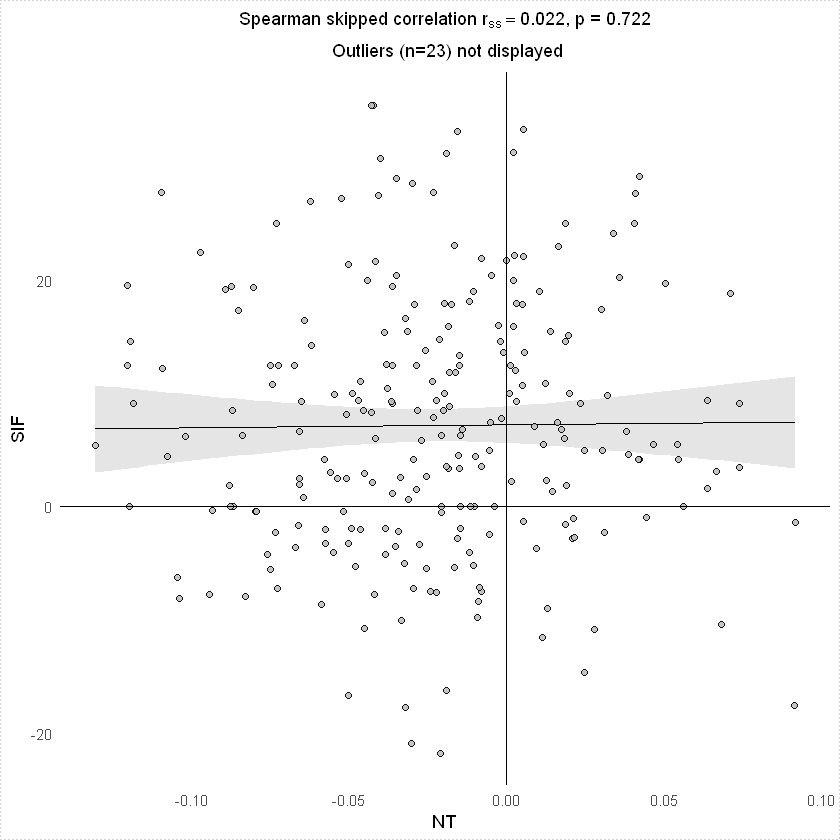

In [18]:
data_sif.psc.ms <- subset(data_sif.psc, data_sif.psc$roi == 'ch12')
x <- data_sif.psc.ms$NT
y <- data_sif.psc.ms$SIF

outliers <- get_outliers(x, "NT", "PSC", y, "SIF", "%", disp = FALSE)
corRes <- doCorrelation(x, y, outliers)
plotCorrelation(x, y,"NT","SIF",corRes, 1.8, 11, outliers, plotoutliers = FALSE) + 
            geom_vline(aes(xintercept = 0), size = 0.1) + geom_hline(aes(yintercept = 0), size = 0.1)